In [362]:
# Sources : 

# Effective Federal Funds Rate (EFFR)
# https://www.newyorkfed.org/markets/reference-rates/effr

# Target Range of the Federal Funds Rate (FFTR)
# https://www.federalreserve.gov/economy-at-a-glance-policy-rate.htm

# TBOND
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025

# ARIMA model
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
pip install --upgrade git+https://github.com/Matteo-Bernard/EcoWatch.git

  Cloning https://github.com/Matteo-Bernard/EcoWatch.git to /private/var/folders/2b/32s1c6ld3y50klj4yfqh9qmc0000gn/T/pip-req-build-m74d69oq
  Running command git clone --filter=blob:none --quiet https://github.com/Matteo-Bernard/EcoWatch.git /private/var/folders/2b/32s1c6ld3y50klj4yfqh9qmc0000gn/T/pip-req-build-m74d69oq
  Resolved https://github.com/Matteo-Bernard/EcoWatch.git to commit 4696ae2378305d7d7d9b6afb346eee2371000b8f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


### Scraping endogène and inendogène datas

In [2]:
from EcoWatch.Scraping import tbond
import numpy as np

# Get the US Treasury Bonds dataset
tbond = tbond('2008', '2024')
tbond = tbond.drop(['20 Yr', '30 Yr'], axis=1) # Drop unrelevant maturities
tbond = tbond.interpolate(axis=1) # Interpolate missing values
tbond = tbond.resample('W').last()
tbond = tbond.dropna(axis=0)

# Define the maturities of the US Treasury Bonds
maturities = np.unique([
    int(col.split()[0]) / 12 if "Mo" in col else int(col.split()[0])
    for col in tbond.columns
])


### Feature Engineering

In [3]:
from EcoWatch.NelsonSiegelCurvature import NSC

# Define parameter bounds for optimization: 
bounds = [(0, 1), (-1, 1), (-1, 1), (0, 5)] # Intercept (β0), Slope (β1), Curvature (β2), and Time delta (λ1)
x0 = [0.01, 0.01, 0.01, 0.5] # Initial guess for the optimization algorithm
method = 'SLSQP' # Optimization method used for minimization

# Create an instance of the Nelson-Siegel-Curvature class
NelsonSiegelCurvature = NSC(maturities=maturities, bounds=bounds, x0=x0, method=method)

# Adjust Nelson-Siegel parameters for the curve
nsc = NelsonSiegelCurvature.fit(yields=tbond)
nsc = nsc.resample('W').last()

Fitting Nelson-Siegel: 0it [00:00, ?it/s]

Fitting Nelson-Siegel: 888it [00:01, 507.98it/s]


In [4]:
# Display the US Treasury Bonds dataset description
print("US Treasury bonds description")
print("==============================================================================")
print(tbond.describe().round(2).to_string()) 
print("\n")

# Display the Nelson-Siegel-Curvature dataset description
print("Neslon Siegel Parameters description")
print("==============================================================================")
print(nsc.describe().round(6).to_string()) 

US Treasury bonds description
         1 Mo    2 Mo    3 Mo    4 Mo    6 Mo    1 Yr    2 Yr    3 Yr    5 Yr    7 Yr   10 Yr
count  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00
mean     1.13    1.17    1.19    1.24    1.27    1.34    1.48    1.65    2.01    2.33    2.61
std      1.71    1.72    1.72    1.72    1.69    1.61    1.42    1.28    1.09    1.00    0.94
min      0.00    0.00    0.00    0.02    0.02    0.04    0.09    0.11    0.21    0.39    0.55
25%      0.04    0.05    0.06    0.08    0.11    0.17    0.38    0.71    1.24    1.55    1.91
50%      0.14    0.16    0.18    0.24    0.32    0.49    0.88    1.27    1.75    2.18    2.54
75%      1.70    1.74    1.81    1.90    1.96    2.07    2.28    2.40    2.65    2.99    3.39
max      6.02    5.60    5.63    5.64    5.61    5.46    5.10    4.93    4.86    4.93    4.93


Neslon Siegel Parameters description
               b1          b2          b3          l1           r
count  888.000000  

### Analyse des ordres des séries

In [5]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf

def correlogram(data, nlags=15, title='Correlogram'):
    c = pd.concat([
        pd.DataFrame(acf(data.dropna(), nlags=nlags+1, qstat=True), index=['ACF', 'Q-stat', 'Prob']).T,
        pd.DataFrame(pacf(data.dropna(), nlags=nlags+1), columns=['PACF']),
    ],axis=1).dropna().round(3)
    print(title)
    print('==============================================================================')
    print(c[['ACF', 'PACF', 'Q-stat', 'Prob']])

In [6]:
data = nsc['b1']
correlogram(data, nlags=15, title=f'β1 - Intercept Correlogram')
print('\n')

print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")   
print('\n')

data = nsc['b2']
correlogram(data, nlags=15, title=f'β2 - Slope Correlogram')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")      
print('\n')

data = nsc['b3']
correlogram(data, nlags=15, title=f'β3 - Intercept Correlogram')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")        
print('\n')

data = nsc['l1']
correlogram(data, nlags=15, title=f'λ1 - Time decay Correlogram')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")             

β1 - Intercept Correlogram
      ACF   PACF     Q-stat  Prob
0   1.000  1.000    864.636   0.0
1   0.985  0.986   1707.248   0.0
2   0.972  0.055   2527.374   0.0
3   0.958 -0.019   3325.335   0.0
4   0.945 -0.008   4101.071   0.0
5   0.931 -0.015   4856.589   0.0
6   0.918  0.030   5589.999   0.0
7   0.904 -0.051   6302.408   0.0
8   0.891  0.004   6993.897   0.0
9   0.877 -0.010   7664.005   0.0
10  0.863 -0.027   8316.306   0.0
11  0.851  0.071   8951.496   0.0
12  0.839  0.011   9569.526   0.0
13  0.827 -0.011  10170.482   0.0
14  0.815 -0.013  10755.381   0.0
15  0.804  0.011  11323.594   0.0


ADF Test : 
ADF Statistic: -1.6596
p-value: 0.452
Critical Values:
   1% : -3.4378
   5% : -2.8648
   10% : -2.5685


β2 - Slope Correlogram
      ACF   PACF     Q-stat  Prob
0   1.000  1.000    871.423   0.0
1   0.989  0.990   1724.056   0.0
2   0.978 -0.017   2559.355   0.0
3   0.967  0.031   3379.659   0.0
4   0.958  0.058   4184.961   0.0
5   0.949 -0.009   4975.322   0.0
6   0.939 -0.0

In [7]:
data = nsc['b1'].diff().dropna()
correlogram(data, nlags=15, title=f'β1 - Intercept Correlogram - diff(1)')
print('\n')

print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")   
print('\n')

data = nsc['b2'].diff().dropna()
correlogram(data, nlags=15, title=f'β2 - Slope Correlogram - diff(1)')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")      
print('\n')

data = nsc['b3'].diff().dropna()
correlogram(data, nlags=15, title=f'β3 - Intercept Correlogram - diff(1)')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")        
print('\n')

data = nsc['l1'].diff().dropna()
correlogram(data, nlags=15, title=f'λ1 - Time decay Correlogram - diff(1)')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")             

β1 - Intercept Correlogram - diff(1)
      ACF   PACF  Q-stat   Prob
0   1.000  1.000   5.587  0.018
1  -0.079 -0.079   7.411  0.025
2   0.045  0.039   7.602  0.055
3   0.015  0.021   8.920  0.063
4   0.038  0.040  11.206  0.047
5  -0.051 -0.047  11.464  0.075
6   0.017  0.006  12.050  0.099
7  -0.026 -0.022  13.285  0.102
8   0.037  0.034  13.397  0.145
9   0.011  0.022  17.157  0.071
10 -0.065 -0.069  17.387  0.097
11  0.016  0.006  17.397  0.135
12 -0.003 -0.002  17.452  0.179
13  0.008  0.013  17.751  0.218
14  0.018  0.025  17.934  0.266
15  0.014  0.011  20.455  0.200


ADF Test : 
ADF Statistic: -32.1886
p-value: 0.0
Critical Values:
   1% : -3.4378
   5% : -2.8648
   10% : -2.5685


β2 - Slope Correlogram - diff(1)
      ACF   PACF  Q-stat   Prob
0   1.000  1.000   0.086  0.769
1   0.010  0.010   0.716  0.699
2  -0.027 -0.027   2.283  0.516
3  -0.042 -0.042   2.285  0.684
4  -0.001 -0.001   3.001  0.700
5  -0.028 -0.031   3.326  0.767
6   0.019  0.018   7.572  0.372
7   0.069  

In [8]:
from statsmodels.tsa.arima.model import ARIMA
nsc_train = nsc.iloc[:int(len(nsc)*0.80)].drop('r', axis=1)
nsc_test = nsc.iloc[-int(len(nsc)*0.20):].drop('r', axis=1)

# Intercept
print('β1 - Intercept Model Summary : ')
print('==============================================================================')
b1_arima = ARIMA(
    nsc_train['b1'], 
    order=(1, 1, 0), # ARIMA(p,d,q) parameters
    trend='n'
).fit()
print(b1_arima.summary())

β1 - Intercept Model Summary : 
                               SARIMAX Results                                
Dep. Variable:                     b1   No. Observations:                  710
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3679.829
Date:                Sat, 31 May 2025   AIC                          -7355.657
Time:                        00:36:53   BIC                          -7346.530
Sample:                    01-06-2008   HQIC                         -7352.131
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1090      0.033     -3.335      0.001      -0.173      -0.045
sigma2      1.816e-06   8.04e-08     22.602      0.000    1.66e-06    1.97e-06
Ljung-Box (L1) (Q): 

C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
from statsmodels.tsa.arima.model import ARIMA
nsc_train = nsc.iloc[:int(len(nsc)*0.80)].drop('r', axis=1)
nsc_test = nsc.iloc[-int(len(nsc)*0.20):].drop('r', axis=1)

# Slope
print('β2 - Slope Model Summary : ')
print('==============================================================================')
b2_arima = ARIMA(
    nsc_train['b2'], 
    order=(4, 1, 0),
    trend='n'
).fit()
print(b2_arima.summary())

β2 - Slope Model Summary : 
                               SARIMAX Results                                
Dep. Variable:                     b2   No. Observations:                  710
Model:                 ARIMA(4, 1, 0)   Log Likelihood                3560.488
Date:                Sat, 31 May 2025   AIC                          -7110.975
Time:                        00:36:53   BIC                          -7088.156
Sample:                    01-06-2008   HQIC                         -7102.160
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0513      0.020     -2.550      0.011      -0.091      -0.012
ar.L2         -0.0558      0.024     -2.330      0.020      -0.103      -0.009
ar.L3         -0.0834   

In [10]:
from statsmodels.tsa.arima.model import ARIMA
nsc_train = nsc.iloc[:int(len(nsc)*0.80)].drop('r', axis=1)
nsc_test = nsc.iloc[-int(len(nsc)*0.20):].drop('r', axis=1)

# Curvature
print('β3 - Curvature Model Summary : ')
print('==============================================================================')
b3_arima = ARIMA(
    nsc_train['b3'], # Curvature    
    order=(4, 1, 2), # ARIMA(p,d,q) parameters
    trend='n' # 'c' for constant, 't' for trend, 'ct' for constant and trend
).fit()
print(b3_arima.summary())

β3 - Curvature Model Summary : 
                               SARIMAX Results                                
Dep. Variable:                     b3   No. Observations:                  710
Model:                 ARIMA(4, 1, 2)   Log Likelihood                3084.663
Date:                Sat, 31 May 2025   AIC                          -6155.325
Time:                        00:36:54   BIC                          -6123.378
Sample:                    01-06-2008   HQIC                         -6142.983
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2286      0.099     -2.304      0.021      -0.423      -0.034
ar.L2         -0.8192      0.104     -7.901      0.000      -1.022      -0.616
ar.L3         -0.079

In [11]:
from statsmodels.tsa.arima.model import ARIMA
nsc_train = nsc.iloc[:int(len(nsc)*0.80)].drop('r', axis=1)
nsc_test = nsc.iloc[-int(len(nsc)*0.20):].drop('r', axis=1)

# Lambda
print('λ1 - time-decay Model Summary : ')
print('==============================================================================')
l1_arima = ARIMA(
    nsc_train['l1'], 
    order=(1, 1, 2),
    trend='n'
).fit()
print(l1_arima.summary())

λ1 - time-decay Model Summary : 
                               SARIMAX Results                                
Dep. Variable:                     l1   No. Observations:                  710
Model:                 ARIMA(1, 1, 2)   Log Likelihood                4778.229
Date:                Sat, 31 May 2025   AIC                          -9548.458
Time:                        00:36:55   BIC                          -9530.203
Sample:                    01-06-2008   HQIC                         -9541.406
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2032      0.010    -19.544      0.000      -0.224      -0.183
ma.L1          0.0385      0.011      3.463      0.001       0.017       0.060
ma.L2         -0.05

In [12]:
correlogram(b1_arima.resid, title='β1 - Intercept Correlogram of Residuals')
correlogram(b1_arima.resid**2, title='β1 - Intercept Correlogram of Squared Residuals')
print('\n')
correlogram(b2_arima.resid, title='β2 - Slope Correlogram of Residuals')
correlogram(b2_arima.resid**2, title='β2 - Slope Correlogram of Squared Residuals')
print('\n')
correlogram(b3_arima.resid, title='β3 - Curvature Correlogram of Residuals')
correlogram(b3_arima.resid**2, title='β3 - Curvature Correlogram of Squared Residuals')
print('\n')
correlogram(l1_arima.resid, title='λ1 - Time-decay Correlogram of Residuals')
correlogram(l1_arima.resid**2, title='λ1 - Time-decay Correlogram of Squared Residuals')

β1 - Intercept Correlogram of Residuals
      ACF   PACF  Q-stat   Prob
0   1.000  1.000   0.017  0.897
1  -0.005 -0.005   0.091  0.956
2  -0.010 -0.010   0.228  0.973
3   0.014  0.014   0.448  0.978
4   0.018  0.018   0.571  0.989
5  -0.013 -0.013   0.810  0.992
6   0.018  0.018   0.817  0.997
7  -0.003 -0.004   0.821  0.999
8   0.002  0.003   1.146  0.999
9   0.021  0.021   2.714  0.987
10 -0.047 -0.048   3.055  0.990
11 -0.022 -0.022   3.986  0.984
12  0.036  0.034   4.491  0.985
13  0.026  0.028   4.681  0.990
14  0.016  0.020   6.760  0.964
15  0.053  0.053   7.189  0.969
β1 - Intercept Correlogram of Squared Residuals
      ACF   PACF  Q-stat   Prob
0   1.000  1.000   0.000  0.984
1  -0.001 -0.001   0.010  0.995
2   0.004  0.004   0.010  1.000
3  -0.001 -0.001   0.011  1.000
4  -0.001 -0.001   0.011  1.000
5  -0.001 -0.001   0.013  1.000
6   0.002  0.002   0.014  1.000
7  -0.001 -0.001   0.035  1.000
8   0.005  0.005   0.036  1.000
9  -0.001 -0.001   0.036  1.000
10 -0.000 -0.000

In [13]:
from tqdm import tqdm
import numpy as np

nsc_pred = nsc_test.copy()
nsc_pred[:] = np.nan
b1_arima_pred = b1_arima
b2_arima_pred = b2_arima
b3_arima_pred = b3_arima
l1_arima_pred = l1_arima

for t in tqdm(nsc_pred.index):
    
    b1_pred = b1_arima_pred.forecast(steps=1, dynamic=False)
    b2_pred = b2_arima_pred.forecast(steps=1, dynamic=False)
    b3_pred = b3_arima_pred.forecast(steps=1, dynamic=False)
    l1_pred = l1_arima_pred.forecast(steps=1, dynamic=False)

    b1_arima_pred = b1_arima_pred.append([pd.Series(nsc_test.loc[t, 'b1'], index=[t])], refit=False)
    b2_arima_pred = b2_arima_pred.append([pd.Series(nsc_test.loc[t, 'b2'], index=[t])], refit=False)
    b3_arima_pred = b3_arima_pred.append([pd.Series(nsc_test.loc[t, 'b3'], index=[t])], refit=False)
    l1_arima_pred = l1_arima_pred.append([pd.Series(nsc_test.loc[t, 'l1'], index=[t])], refit=False)

    nsc_pred.loc[t] = [
        b1_pred.values[0], 
        b2_pred.values[0], 
        b3_pred.values[0], 
        l1_pred.values[0]
    ]

100%|██████████| 177/177 [00:33<00:00,  5.32it/s]


In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

def mean_percentage_error(test, pred):
    test, pred = np.array(test), np.array(pred)
    return np.mean((test - pred) / test)

def eval(test, pred):
    tbond_eval = pd.DataFrame(index=['RMSE', 'MSE', 'MAPE (%)', 'MPE (%)', 'MAE'], columns=test.columns)

    for n in test.columns:
        y_true = test[n].values
        y_pred = pred[n].values

        tbond_eval.loc['RMSE', n]     = f"{root_mean_squared_error(y_true, y_pred):.4f}"
        tbond_eval.loc['MSE', n]      = f"{mean_squared_error(y_true * 1000, y_pred * 1000):.2f}"
        tbond_eval.loc['MAPE (%)', n] = f"{mean_absolute_percentage_error(y_true, y_pred):.2%}"
        tbond_eval.loc['MPE (%)', n]  = f"{mean_percentage_error(y_true, y_pred):.2%}"
        tbond_eval.loc['MAE', n]      = f"{mean_absolute_error(y_true * 1000, y_pred * 1000):.2f}"

    return tbond_eval

eval(nsc_test, nsc_pred)

,b1,b2,b3,l1
RMSE,0.0017,0.0024,0.0047,0.0002
MSE,2.94,5.56,22.35,0.05
MAPE (%),4.33%,28.78%,22.35%,0.03%
MPE (%),0.66%,-8.31%,-4.77%,-0.00%
MAE,1.37,1.78,2.81,0.14


In [41]:
def nsc_to_curve(P, T):
    """Calcule la courbe Nelson-Siegel pour un jeu de paramètres P et des maturités T."""
    return (P[0] +
            P[1] * ((1 - np.exp(-T / P[3])) / (T / P[3])) +
            P[2] * (((1 - np.exp(-T / P[3])) / (T / P[3])) - np.exp(-T / P[3])))

tbond_pred = pd.DataFrame(columns=tbond.columns, index=nsc_pred.index)
for t in nsc_pred.index:
    tbond_pred.loc[t] = nsc_to_curve(P=nsc_pred.loc[t].values, T=maturities)
tbond_test = tbond.loc[tbond_pred.index[0]:]/100

In [42]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def mean_percentage_error(test, pred):
    test, pred = np.array(test), np.array(pred)
    return np.mean((test - pred) / test)

tbond_eval = pd.DataFrame(columns=tbond_pred.columns)
for n in tbond_pred.columns:
        test = tbond_test[n].dropna()
        pred = tbond_pred[n].dropna()

        tbond_eval.loc['RMSE', n]  = f"{root_mean_squared_error(test, pred):.4f}"
        tbond_eval.loc['MSE', n]  = f"{mean_squared_error(test*1000, pred*1000):.2f}"
        tbond_eval.loc['MAPE (%)', n] = f"{mean_absolute_percentage_error(test, pred):.2%}"
        tbond_eval.loc['MPE (%)', n] = f"{mean_percentage_error(test, pred):.2%}"
        tbond_eval.loc['MAE', n]  = f"{mean_absolute_error(test*1000, pred*1000):.2f}"

tbond_eval

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr
RMSE,0.0019,0.0013,0.0010,0.0013,0.0013,0.0014,0.0018,0.0019,0.0016,0.0016,0.0018
MSE,3.54,1.61,1.05,1.63,1.66,2.06,3.07,3.48,2.69,2.66,3.24
MAPE (%),38.46%,9.18%,10.20%,19.60%,23.32%,7.58%,7.72%,6.59%,4.24%,4.44%,4.97%
MPE (%),-27.37%,-3.32%,8.98%,19.19%,22.26%,5.22%,-4.04%,-2.51%,-0.35%,2.30%,2.88%
MAE,1.14,0.79,0.66,0.92,0.93,1.00,1.34,1.48,1.29,1.34,1.49


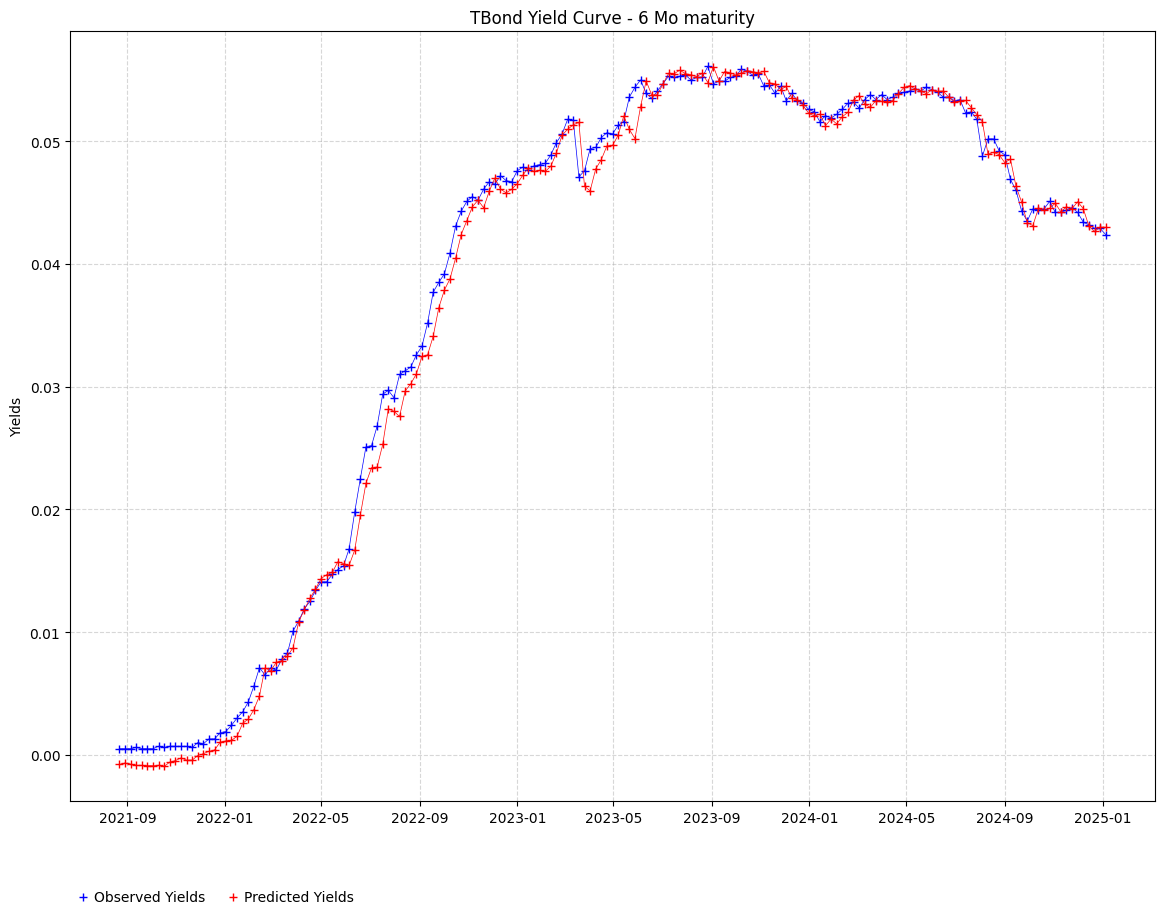

In [45]:
import matplotlib.pyplot as plt

t='6 Mo'
fig, ax1 = plt.subplots(figsize=(14,10))

# Plot of observed bond yields
ax1.plot(tbond_pred.index, tbond_test[t], color='blue', linestyle='-', marker='+', linewidth=0.5, label="Observed Yields")
ax1.plot(tbond_pred.index, tbond_pred[t], color='red', linestyle='-', marker='+', linewidth=0.5, label="Predicted Yields")
ax1.set_ylabel('Yields', color='black')

ax1.legend(bbox_to_anchor=(0, -0.15), loc='lower left', ncol=2, frameon=False, handlelength=0)


# Set plot title with the last available date in the dataset
plt.title(f"TBond Yield Curve - {t} maturity")
plt.grid(alpha=0.5, linestyle='--')

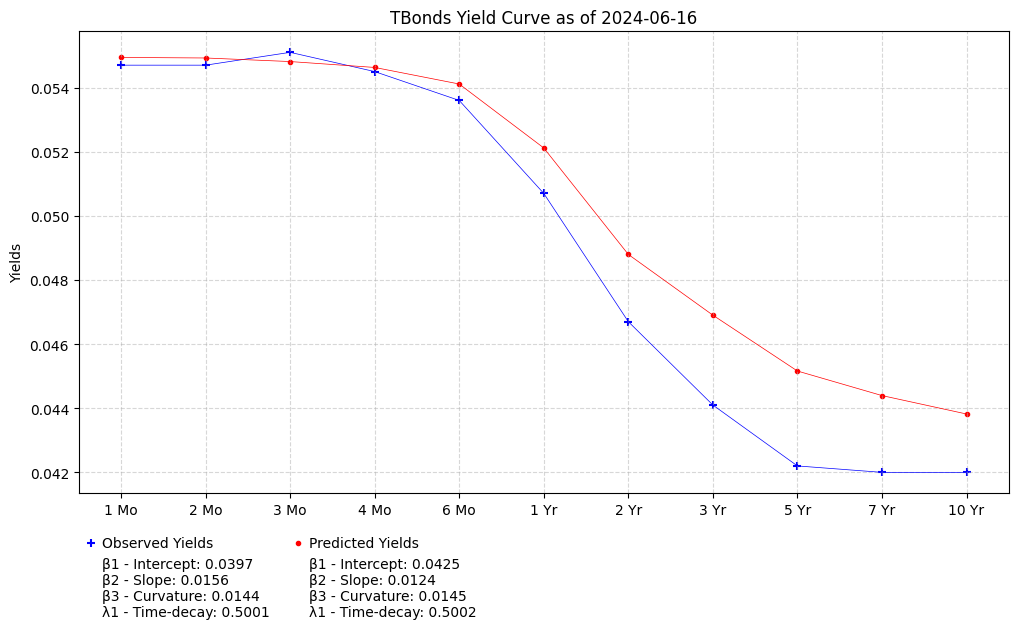

In [370]:
import matplotlib.pyplot as plt

x=-30
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot of observed bond yields
ax1.scatter(x=tbond.columns, y=np.array(tbond.iloc[x])/100, color='blue', marker='+', label="Observed Yields")
ax1.plot(tbond.columns, np.array(tbond.iloc[x])/100, color='blue', linestyle='-', linewidth=0.5)
ax1.set_ylabel('Yields', color='black')
ax1.tick_params(axis='y', colors='black')

# Plot of predicted bond yields
ax1.scatter(x=tbond_pred.columns, y=tbond_pred.iloc[x], color='red', marker='.', label="Predicted Yields")
ax1.plot(tbond_pred.columns, tbond_pred.iloc[x], color='red', linestyle='-', linewidth=0.5)

# Format Nelson-Siegel parameters as text for legend
params_test = (
    f"β1 - Intercept: {nsc_test['b1'].iloc[x]:.4f}\n"
    f"β2 - Slope: {nsc_test['b2'].iloc[x]:.4f}\n"
    f"β3 - Curvature: {nsc_test['b3'].iloc[x]:.4f}\n"
    f"λ1 - Time-decay: {nsc_test['l1'].iloc[x]:.4f}"
)
params_pred = (
    f"β1 - Intercept: {nsc_pred['b1'].iloc[x]:.4f}\n"
    f"β2 - Slope: {nsc_pred['b2'].iloc[x]:.4f}\n"
    f"β3 - Curvature: {nsc_pred['b3'].iloc[x]:.4f}\n"
    f"λ1 - Time-decay: {nsc_pred['l1'].iloc[x]:.4f}"
)

# Créer des dummy lines pour afficher les paramètres
dummy_test = plt.Line2D([], [], color="white", label=params_test)
dummpred = plt.Line2D([], [], color="white", label=params_pred)

# Récupérer les handles et labels
handles, labels = ax1.get_legend_handles_labels()

# Insérer les paramètres juste après les points correspondants
new_handles = []
new_labels = []

for h, l in zip(handles, labels):
    new_handles.append(h)
    new_labels.append(l)
    if l == "Observed Yields":
        new_handles.append(dummy_test)
        new_labels.append(params_test)
    elif l == "Predicted Yields":
        new_handles.append(dummpred)
        new_labels.append(params_pred)

# Afficher la légende avec 2 colonnes côte à côte
ax1.legend(new_handles, new_labels, bbox_to_anchor=(0, -0.3), loc='lower left', ncol=2, frameon=False, handlelength=0)

# Set plot title with the last available date in the dataset
plt.title(f"TBonds Yield Curve as of {nsc_pred.index[x].strftime('%Y-%m-%d')}")
plt.grid(alpha=0.5, linestyle='--')